In [537]:
import pandas as pd
import reverse_geocoder as rg
import numpy as np
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim 
from googletrans import Translator, constants
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
translator = Translator()
geolocator = Nominatim(user_agent="geoapiExercises")

In [538]:
def createSubSet(cluster_i):
    cluster1DF = pd.DataFrame.from_records(cluster_i)
    cluster1DF.rename(columns={0: 'Latitude',1: 'Longitude'}, inplace=True)
    joined = cluster1DF.merge(full_combined_dataset,
              how='right',
              on =['Latitude', 'Longitude'],
             )
    return joined

In [539]:
def findDays(year, month, day, yearold, monthold, dayold):
    from datetime import date
    year, month, day, yearold, monthold, dayold = int(year), int(month), int(day), int(yearold), int(monthold), int(dayold)
    d1 = date(year, month, day)
    d0 = date(yearold, monthold, dayold)
    delta = d1 - d0
    return delta.days

In [540]:
def findDaysSince1965(clusterDF):
    count = 0
    cluster1_1 = clusterDF
    cluster1_1['daysSince1965'] = np.nan

    for i, r, in cluster1_1.iterrows():

        days = findDays(r['Year'], r['Month'], r['Day'], 1965, 1, 1)
        cluster1_1['daysSince1965'][count] = days
        count +=1


    cluster1_1 = cluster1_1.sort_values('daysSince1965')

    return cluster1_1

def findGap(daysSince, newDaysSince):
    return daysSince - newDaysSince
    

In [541]:
def addGapToDF(cluster):
    cluster1 = findDaysSince1965(cluster)
    count = 0
    cluster1['Gap'] = np.nan

    for i, r, in cluster1.iterrows():

        if count > 0:
            gap = findGap(r['daysSince1965'], f['daysSince1965'])

            cluster1['Gap'][count] = gap
        f = r
        count +=1
    cluster1 = cluster1.iloc[1: , :]

    return cluster1

In [542]:
def find_x_y_set(cluster1):
    depth_gap = cluster1.iloc[:, [2, -2]].values
    magnitude = cluster1.iloc[:, 3].values
    
    x = depth_gap
    y = magnitude
    
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.005, random_state = 0)
    return X_train,y_train, X_test, y_test
    

In [543]:

def decisionTreeRegression(x,y,dept = 482.90, daysSince = 27):
    regressor = DecisionTreeRegressor(random_state = 0)
    regressor.fit(x, y)
    #score = regressor.score(x, y)    
    # Predicting a new result
    y_pred = regressor.predict([[dept,daysSince]])
    
    ax = plt.axes(projection='3d')
    # Visualising the Decision Tree Regression results (higher resolution)
    ax.scatter3D(x[:,1], x[:,0], y, c=x[:,1], cmap='Greens');
    ax.set_xlabel('Days since last earthquake')
    ax.set_ylabel('Depth')
    ax.set_zlabel('Magnitude')
    print('Decision Tree Regression Pred:', 'Magnitude:',y_pred ,  'Score:',score)
    return y_pred, regressor


In [544]:

def regressions(X,y,predValue, xLabel, CLUSTER_NUMBER):

    # Training the Linear Regression model on the whole dataset

    lin_reg = LinearRegression()
    lin_reg.fit(X, y)

    # Training the Polynomial Regression model on the whole dataset
   
    poly_reg = PolynomialFeatures(degree = 4)
    X_poly = poly_reg.fit_transform(X)
    lin_reg_2 = LinearRegression()
    lin_reg_2.fit(X_poly, y)


    # Visualising the Linear Regression results
    plt.scatter(X, y, color = 'red')
    plt.plot(X, lin_reg.predict(X), color = 'blue')
    plt.title('Cluster ' + str(CLUSTER_NUMBER) + '(Linear Regression)')
    plt.xlabel(xLabel)
    plt.ylabel('Magnitude')
    plt.show()

    # Visualising the Polynomial Regression results
    X_grid = np.arange(min(X), max(X), 0.1)
    X_grid = X_grid.reshape((len(X_grid), 1))
    plt.scatter(X, y, color = 'red')
    plt.plot(X_grid, lin_reg_2.predict(poly_reg.fit_transform(X_grid)), color = 'blue')
    plt.title('Cluster ' + str(CLUSTER_NUMBER) + ' (Polynomial Regression)')
    plt.xlabel(xLabel)
    plt.ylabel('Magnitude')
    plt.show()

    linearPred = lin_reg.predict([[predValue]])
    polyPred = lin_reg_2.predict(poly_reg.fit_transform([[predValue]]))
    # Predicting a new result with Linear Regression
    print('Linear Regression Pred: ', linearPred)
    
    
    # Predicting a new result with Polynomial Regression
    print('Polynomial Regression Pred: ', polyPred)

    
    return linearPred[0], lin_reg, polyPred[0], lin_reg_2, poly_reg
    

In [545]:

def decide_x_y_for_regression(cluster1_new,depthAlone, depth_pred, days_pred, graph):
    depth_gap = cluster1_new.iloc[:, [2, -2]].values
    depth = cluster1_new.iloc[:, [2]].values
    magnitude = cluster1_new.iloc[:, 3].values
    just_gap = cluster1_new.iloc[:, [-2]].values

    y = magnitude

    if depthAlone:
        X = depth
        xLabel = 'Depth'
        predValue = depth_pred
    else:
        X = just_gap
        xLabel = 'Days since last earthquake'
        predValue = days_pred
    
    if graph == True:
        return X,y,predValue,xLabel
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.005, random_state = 0)
        return X_train, y_train, X_test, y_test, predValue, xLabel


In [546]:
# Support Vector Regression (SVR)

def supportVectorRegressionGraph(X,y,predValue, xLabel, CLUSTER_NUMBER):
    
    y = y.reshape(len(y),1)
    # Feature Scaling

    sc_X = StandardScaler()
    sc_y = StandardScaler()
    X = sc_X.fit_transform(X)
    y = sc_y.fit_transform(y)

    # Training the SVR model on the whole dataset
 
    regressor = SVR(kernel = 'rbf')
    regressor.fit(X, y.ravel())
    pred = sc_y.inverse_transform(regressor.predict(sc_X.transform([[predValue]])))
    # Visualising the SVR results
    plt.scatter(sc_X.inverse_transform(X), sc_y.inverse_transform(y.ravel()), color = 'red')
    plt.plot(sc_X.inverse_transform(X), sc_y.inverse_transform(regressor.predict(X)), color = 'blue')
    plt.title('Cluster '+ str(CLUSTER_NUMBER) +   '(Support Vector Regression)')
    plt.xlabel(xLabel)
    plt.ylabel('Magnitude')
    plt.show()

    # Visualising the SVR results (for higher resolution and smoother curve)
    X_grid = np.arange(min(sc_X.inverse_transform(X)), max(sc_X.inverse_transform(X)), 0.1)
    X_grid = X_grid.reshape((len(X_grid), 1))
    
    plt.scatter(sc_X.inverse_transform(X), sc_y.inverse_transform(y), color = 'red')
    plt.plot(X_grid, sc_y.inverse_transform(regressor.predict(sc_X.transform(X_grid))), color = 'blue')
    plt.title('Cluster '+ str(CLUSTER_NUMBER) +   ' (Support Vector Regression)')
    plt.xlabel(xLabel)
    plt.ylabel('Magnitude')
    plt.show()

    # Predicting a new result
    print('SVR Model pred: ',pred)
    return pred, regressor

In [547]:
def vectorMSE(X_test,y_test, vector_regressor):
    i = 0
    vector_pred = []
    sc_X = StandardScaler()
    sc_y = StandardScaler()

    y_test_vector = y_test.reshape(-1, 1)
    X_test_vector = X_test.reshape(-1, 1)
    for f in X_test_vector:
        f = f.reshape(1, -1)      
        y = y_test_vector[i].reshape(1, -1) 
        f = sc_X.fit_transform(f)
        y = sc_y.fit_transform(y)
        pred = sc_y.inverse_transform(vector_regressor.predict(f))
        vector_pred.append(pred[0]) #sc_X.transform([[f]])
        i +=1

    return mean_squared_error(y_test, vector_pred, squared=False)

In [548]:
def findPolyLinMSE(X_test,y_test, lin_regressor, poly_regressor, poly_reg):
    linear_pred = []
    poly_pred = []
    
    for f in X_test:
        linearPred = lin_regressor.predict([f])
        linear_pred.append(linearPred[0])

        polyPred = poly_regressor.predict(poly_reg.fit_transform([f]))  
        poly_pred.append(polyPred[0])

    poly_MSE = mean_squared_error(y_test, poly_pred, squared=False)
    lin_MSE = mean_squared_error(y_test, linear_pred, squared=False)
    return poly_MSE,lin_MSE

In [549]:
def findDecisionMSE(X_test,y_test, regressor_decision):
    dec_pred = []
    for x in x_test_decision:
        y_pred = regressor_decision.predict([x])
        dec_pred.append(y_pred[0])

    return mean_squared_error(y_test, dec_pred, squared=False)

In [550]:
def average(lst):
    return sum(lst) / len(lst)

###### Take in Dataset 

In [551]:
full_combined_dataset = pd.read_csv('clean_data.csv', delimiter=',', encoding="utf-8")
full_combined_dataset = full_combined_dataset.drop(columns=full_combined_dataset.columns[0])
dataset = full_combined_dataset.iloc[:, [0,1]].values # init dataset to value we want to cluster

###### Plot Elbow graph to understand best amount of clusters

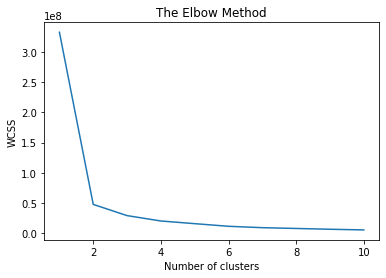

In [552]:

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(dataset) # X = combined dataset
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


NUMBER_CLUSTERS = 10 # 10 clusters used despite elbow graph for earthquakes
kmeans = KMeans(init = 'k-means++',n_clusters=NUMBER_CLUSTERS ,random_state = 42)
y_kmeans = kmeans.fit_predict(dataset)

silhouetteScore = silhouette_score(dataset,y_kmeans)

###### Plot Clusters

In [553]:
import plotly

import plotly.graph_objs as go
plotly.offline.init_notebook_mode()

import pandas as pd

colors = ['orange','purple','gray','pink','red','green','blue', 'yellow', 'olive', 'brown']

fig = go.Figure(go.Scattergeo())

for x in range(NUMBER_CLUSTERS):
    fig.add_trace(go.Scattermapbox(
        lat = dataset[y_kmeans == x, 0],
        lon = dataset[y_kmeans == x, 1],
        mode = 'markers',
        name = 'Cluster ' + str(x+1),
        marker = go.scattermapbox.Marker(
            size = 4,
            color = colors[x],
            opacity = 0.9
        ),
))
 

fig.add_trace(go.Scattermapbox(
    lat = kmeans.cluster_centers_[:, 0],
    lon = kmeans.cluster_centers_[:, 1],
    mode = 'markers',
    name = 'Centroids',
    marker = go.scattermapbox.Marker(
        size = 12,
        color = 'Yellow',
        opacity = 0.9
    ),
))


MAPBOX_TOKEN = 'pk.eyJ1IjoibHVrZWNvYnVybjEyMyIsImEiOiJja3l5dWh5cXQwN3RxMm9vMXp3c2lid2t5In0.mazcpXEbtKNZtbG9j_NpFg'
fig.update_mapboxes(accesstoken=MAPBOX_TOKEN)


fig.update_layout(height=700, margin={"r":0,"t":0,"l":0,"b":0})
#fig = go.Figure(layout=layout, data=cases)
fig.show()
#plotly.offline.iplot(fig, validate=False, filename='iantest')

###### Implement Support Vector Regression method and find its MSE across all clusters

Decision Tree Regression Pred: Magnitude: [5.9] Score: 0.5707938900156451
Decision Tree Regression Pred: Magnitude: [5.9] Score: 0.5707938900156451
Decision Tree Regression Pred: Magnitude: [5.6] Score: 0.5707938900156451
Decision Tree Regression Pred: Magnitude: [5.6] Score: 0.5707938900156451
Decision Tree Regression Pred: Magnitude: [5.9] Score: 0.5707938900156451
Decision Tree Regression Pred: Magnitude: [5.6] Score: 0.5707938900156451
Decision Tree Regression Pred: Magnitude: [5.6] Score: 0.5707938900156451
Decision Tree Regression Pred: Magnitude: [5.6] Score: 0.5707938900156451
Decision Tree Regression Pred: Magnitude: [5.6] Score: 0.5707938900156451
Decision Tree Regression Pred: Magnitude: [5.6] Score: 0.5707938900156451


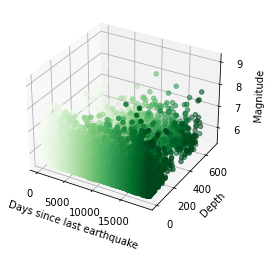

In [554]:
vectorMeanSquaredError_avg,poly_MSE_avg,lin_MSE_avg, decisionMSE_avg = [],[],[],[]
for CLUSTER_NUMBER in range(NUMBER_CLUSTERS):
    pd.options.mode.chained_assignment = None
    cluster_i = dataset[y_kmeans == CLUSTER_NUMBER] 
    cluster = createSubSet(cluster_i)
    cluster = addGapToDF(cluster)

    x_decision, y_decision, x_test_decision, y_test_decision = find_x_y_set(cluster)
    depth, days = 350,10
    prediction_decision, regressor_decision = decisionTreeRegression(x_decision,y_decision,depth, days)
    decisionMSE = findDecisionMSE(x_test_decision, y_test_decision,regressor_decision)
    
    decisionMSE_avg.append(decisionMSE)

###### Implement polynominal, linear and descision tree Regression methods and find their MSE across all clusters

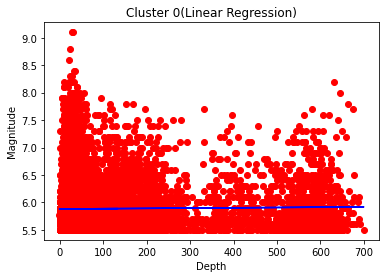

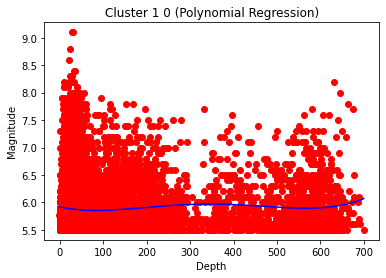

Linear Regression Pred:  [5.90035084]
Polynomial Regression Pred:  [5.97063187]


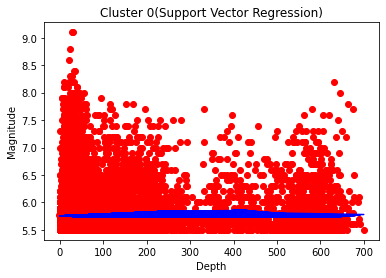

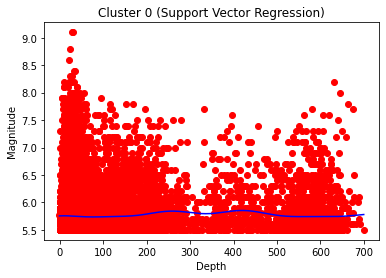

SVR Model pred:  [5.79940052]


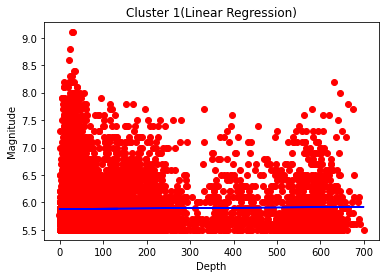

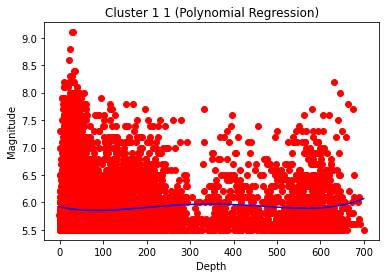

Linear Regression Pred:  [5.90031128]
Polynomial Regression Pred:  [5.97092948]


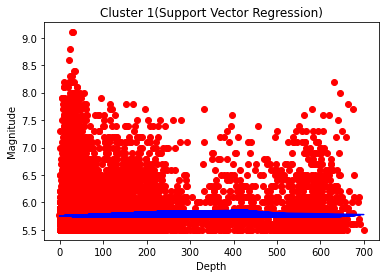

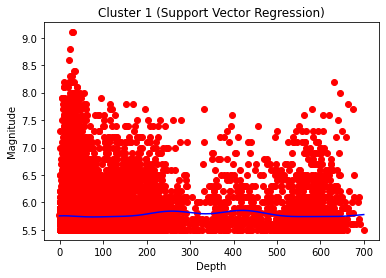

SVR Model pred:  [5.79794616]


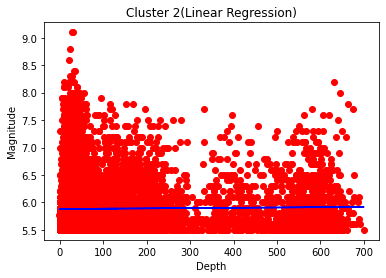

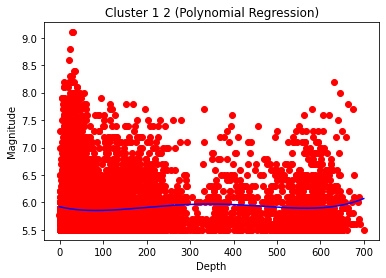

Linear Regression Pred:  [5.90031641]
Polynomial Regression Pred:  [5.97081918]


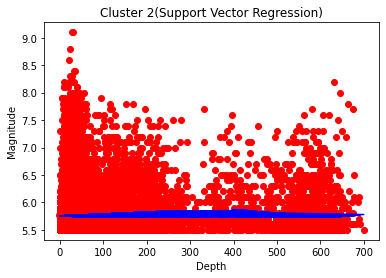

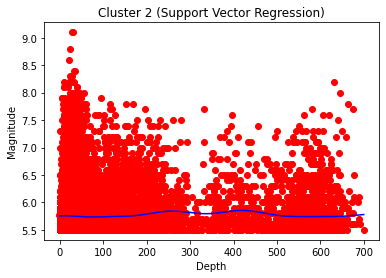

SVR Model pred:  [5.79922073]


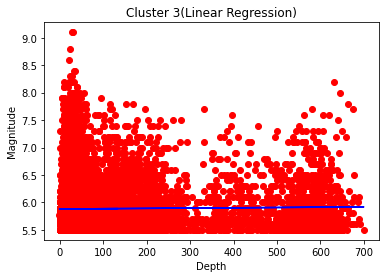

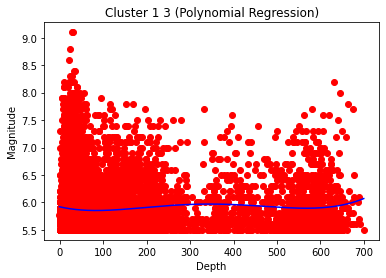

Linear Regression Pred:  [5.90031641]
Polynomial Regression Pred:  [5.97081918]


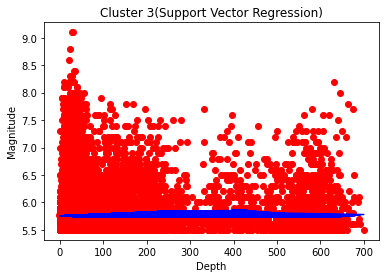

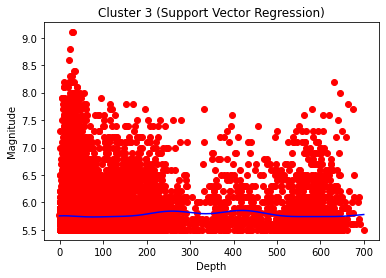

SVR Model pred:  [5.79922073]


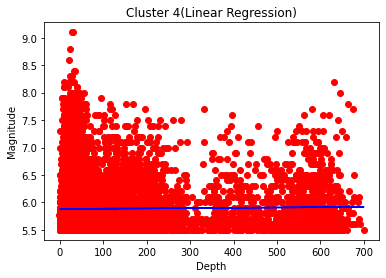

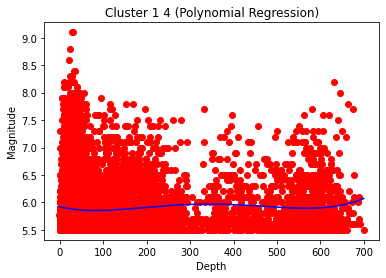

Linear Regression Pred:  [5.90026647]
Polynomial Regression Pred:  [5.97108063]


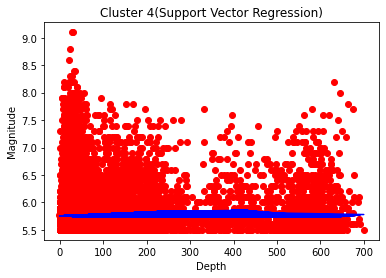

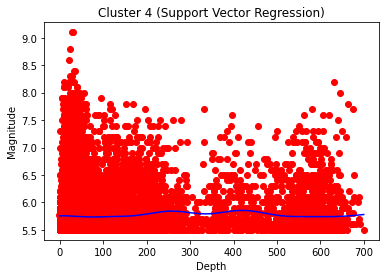

SVR Model pred:  [5.79696035]


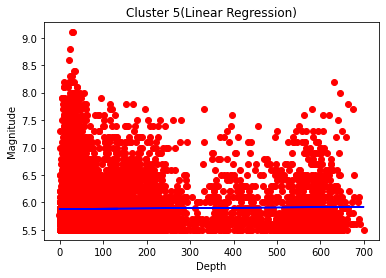

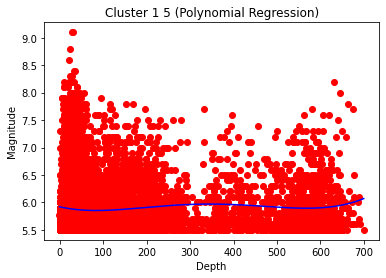

Linear Regression Pred:  [5.90031641]
Polynomial Regression Pred:  [5.97081918]


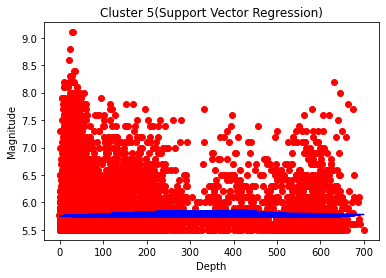

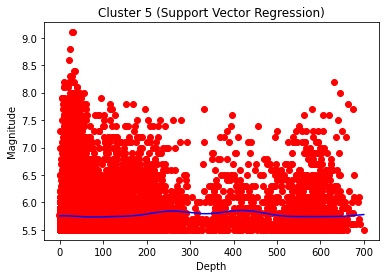

SVR Model pred:  [5.79922073]


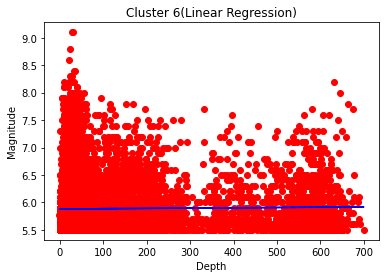

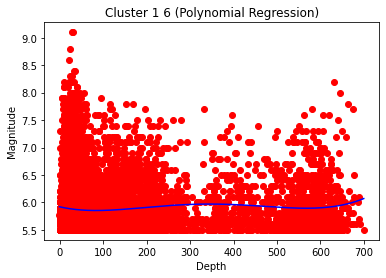

Linear Regression Pred:  [5.90031641]
Polynomial Regression Pred:  [5.97081918]


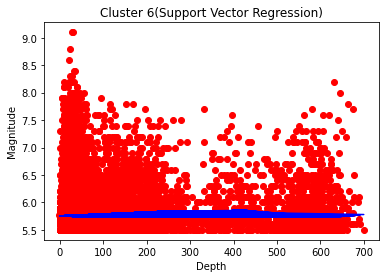

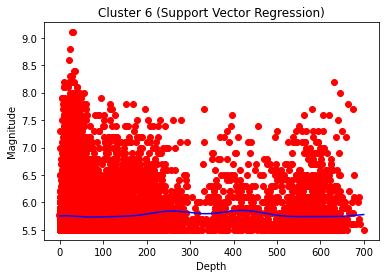

SVR Model pred:  [5.79922073]


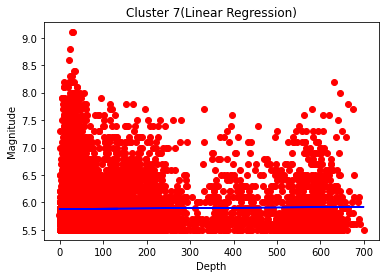

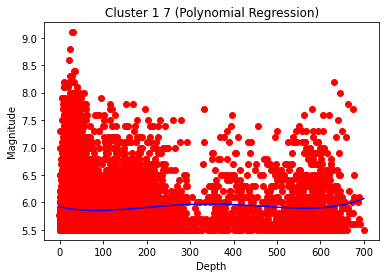

Linear Regression Pred:  [5.90031641]
Polynomial Regression Pred:  [5.97081918]


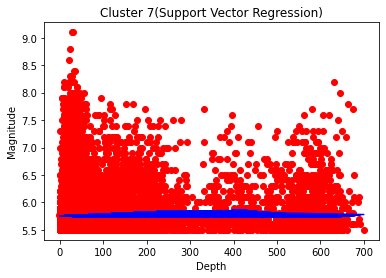

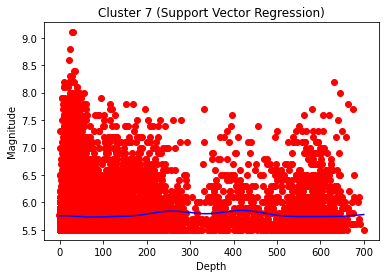

SVR Model pred:  [5.79922073]


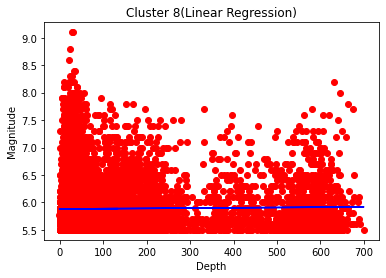

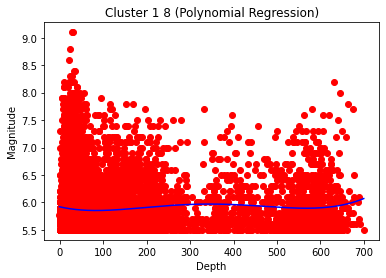

Linear Regression Pred:  [5.90031641]
Polynomial Regression Pred:  [5.97081918]


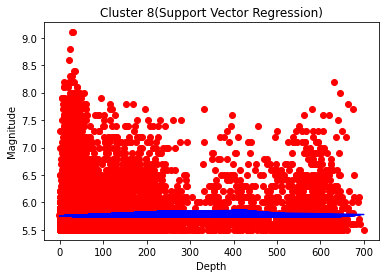

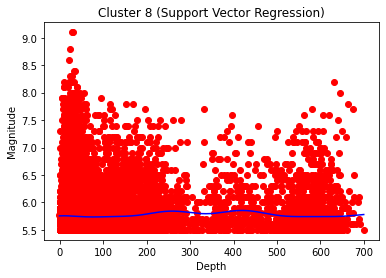

SVR Model pred:  [5.79922073]


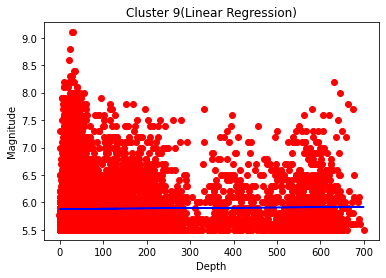

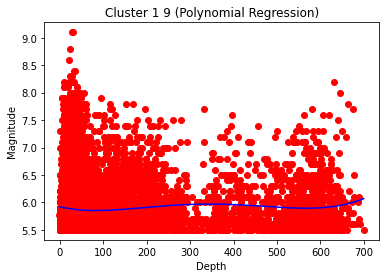

Linear Regression Pred:  [5.90031641]
Polynomial Regression Pred:  [5.97081918]


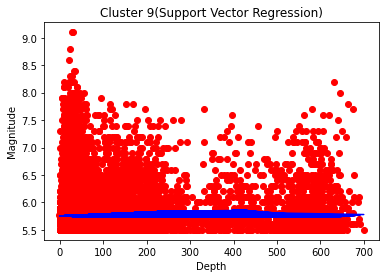

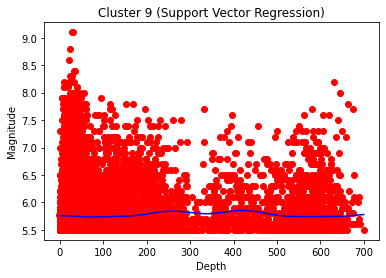

SVR Model pred:  [5.79922073]


In [555]:
for CLUSTER_NUMBER in range(NUMBER_CLUSTERS):
    #CLUSTER_NUMBER = randint(0, NUMBER_CLUSTERS)
    pd.options.mode.chained_assignment = None
    cluster_i = dataset[y_kmeans == CLUSTER_NUMBER] 
    cluster = createSubSet(cluster_i)
    
    X,y,predValue,xLabel = decide_x_y_for_regression(cluster, True, depth, days, True) 
    lin_pred, lin_regressor, poly_pred, poly_regressor,poly_reg = regressions(X,y,predValue,xLabel, CLUSTER_NUMBER)
    vector_pred, vector_regressor = supportVectorRegressionGraph(X,y,predValue,xLabel,CLUSTER_NUMBER)
    
    X,y,X_test,y_test,predValue,xLabel = decide_x_y_for_regression(cluster, True, depth, days, False) 
    vectorMeanSquaredError = vectorMSE(X_test,y_test, vector_regressor)
    poly_MSE,lin_MSE = findPolyLinMSE(X_test,y_test, lin_regressor, poly_regressor, poly_reg) 
    
    
    poly_MSE_avg.append(poly_MSE)
    lin_MSE_avg.append(lin_MSE)
    vectorMeanSquaredError_avg.append(vectorMeanSquaredError)


In [559]:
b

Silhouette score of K-Means: 0.5707938900156451

Average mean squared error across clusters:
   Polynomial Regression: 0.44859023486459354
   Linear Regression: 0.4483609558617129
   Decision Tree Regression: 0.548296880649331
   Support Vector Regression: 0.3509424030711166

